In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import plot_utils
sns.set_style("darkgrid")

In [2]:
ETA_LATEX = r"$\overline{\eta}$"
RENAME_DICT = {
    "test_acc": "Test Accuracy",
    "train_acc": "Train Accuracy",
    "alpha_cor_mf": "Capacity",
    "R_M_cor": "Radius",
    "D_M_cor": "Dimension",
    "cor_center": "Center Alignment",
    "cor_axes": "Axes Alignment",
    "cor_center_axes": "Center-Axes Alignment",
    "severity": "Severity",
    "corruption": "Corruption",
    "eta": ETA_LATEX,
    "normalized_weight_diff": "Relative Norm Change",
    "activation_stability": "Activation Stability",
    "capacity": "Capacity",
    "radius": "Radius",
    "dimension": "Dimension",
    "center_alignment": "Center Alignment",
    "axes_alignment": "Axes Alignment",
    "center_axes_alignment": "Center-Axes Alignment"
}
max_epoch = 100

In [3]:
def append_columns(df, df_with_colname, col_name):
    """ Create a new dataframe from `df`, with new column `col_name` with unique values from `df_with_colname`
    For each unique values of `col_name` in `df_with_colname`, make a copy of `df`. The newly created `df` is the concatenation of these copies."""
    unique_vals = df_with_colname[col_name].unique()
    df_list = []
    for val in unique_vals:
        sub_df = df.copy()
        sub_df[col_name] = val
        df_list.append(sub_df)
    new_df = pd.concat(df_list)
    return new_df

def join_dfs(input_df_1, input_df_2, idx_cols):
    df_1 = input_df_1.copy().set_index(idx_cols)
    df_2 = input_df_2.copy().set_index(idx_cols)
    joined_df = df_1.join(df_2, how="inner").reset_index()
    return joined_df

def plot_results_sns(input_df, plot_var, x, cols_to_plot, query="", figsize=(3,4), use_log=True, colormap=None, fig_title=None, plus_one=True, xlabel=None, plot_sem=False, marker=None, model_cols=[], col_title=""):
    fig_height, fig_width = figsize
    if len(query) > 0:
        df = input_df.query(query).copy()
    else:
        df = input_df.copy()
    var_list = sorted(df[plot_var].unique())
    if colormap is None:
        colors = sns.cubehelix_palette(len(var_list))
    else:
        colors = sns.color_palette(colormap, len(var_list))
    try:
        if all(val.is_integer() for val in df[plot_var]):
            df[plot_var] = df[plot_var].apply(lambda x: str(int(x)))
            hue_order = [str(i) for i in sorted([int(j) for j in df[plot_var].unique()])]
        else:
            df[plot_var] = df[plot_var].apply(lambda x: str(round(float(x),3)))
            hue_order = [str(i) for i in sorted([float(j) for j in df[plot_var].unique()])]
    except:
        hue_order = [str(i) for i in sorted([j for j in df[plot_var].unique()])]
        df[plot_var] = df[plot_var].apply(lambda x: str(x))
    #hue_order = ["CIFAR-10", "CIFAR-10C", "CIFAR-100"]
    fig, axs = plt.subplots(1, len(cols_to_plot))
    fig.set_figheight(fig_height)
    fig.set_figwidth(len(cols_to_plot)*fig_width)

    # fig, axs = plt.subplots(len(cols_to_plot), 1)
    # fig.set_figwidth(fig_width)
    # fig.set_figheight(len(cols_to_plot)*fig_height)
    if len(cols_to_plot) == 1:
        axs = [axs]
    if plus_one:
        df[x] = df[x] + 1
    for i, col in enumerate(cols_to_plot):
        if col in model_cols:
            df_col = df.copy()[[plot_var, x, "seed", col]].drop_duplicates() # model cols have no `subSeed`
        else:
            df_col = df.copy()
        if i == 0:
            sns.lineplot(df_col, x=x, y=col, hue=plot_var, legend="full", ax=axs[i], hue_order=hue_order, palette=colors, marker=marker, dashes=False)
            # axs[i].set_xticks([])
            # axs[i].set_xticklabels([])
            #axs[i].set_xlabel("")
            axs[i].legend(bbox_to_anchor=(1.2, 1), title=plot_var, title_fontsize=16)
        if i < len(cols_to_plot) - 1:
            sns.lineplot(df_col, x=x, y=col, hue=plot_var, legend=False, ax=axs[i], hue_order=hue_order, palette=colors, marker=marker, dashes=False)
            # axs[i].set_xticks([])
            # axs[i].set_xticklabels([])
            #axs[i].set_xlabel("")
        else:
            sns.lineplot(df_col, x=x, y=col, hue=plot_var, legend=False, ax=axs[i], hue_order=hue_order, palette=colors, marker=marker, dashes=False)
            #axs[i].legend(bbox_to_anchor=(0.7, -0.4), title="Feature Learning Strength", title_fontsize=12, ncol=4)
        # axs[i].set_ylabel("")
        axs[i].set_title(col + col_title)
        # axs[i].set_ylim([0, None])
        if use_log:
            axs[i].set_xscale('log')


    if fig_title is None:
        if len(query) > 0:
            fig.suptitle(query)
    else:
        fig.suptitle(fig_title)
    plt.tight_layout()
    return fig

def plot_heatmap(df):
    plt.matshow(df, cmap ="Blues")
    plt.colorbar() 
    # Assigning labels of x-axis according to dataframe 
    plt.xticks(range(len(df.columns)), df.columns, fontsize=8)
    plt.xlabel(ETA_LATEX, fontsize=14)
    # Assigning labels of y-axis according to dataframe 
    plt.yticks(range(len(df.index)), df.index) 
    # Displaying the figure
    plt.grid(False)
    plt.show()


## Model training results

In [4]:
# vgg
model_training_folder = "/mnt/home/hlethi/ceph/learningGeometry_20240510/model_training/training_state"
model_training_template = "alpha-{alpha}_decay-0.0_lr-1.0_model-VGG11_optim-SGD_seed-{seed}_task-CIFAR-10.pkl"

In [5]:
model_training_df = plot_utils.load_results_to_df(model_training_folder, model_training_template, sub_folders=False)
# get average proportion lazy
model_training_df["activation_stability"] = model_training_df["proportion_lazy"].apply(lambda x: sum(x) / len(x))
model_training_df = model_training_df.drop(columns=["proportion_lazy"])
display(model_training_df)

cache_filename='/mnt/home/hlethi/ceph/learningGeometry_20240510/model_training/training_state/alpha-_decay-0.0_lr-1.0_model-VGG11_optim-SGD_seed-_task-CIFAR-10.pkl'


,alpha,seed,epoch,train_loss,train_loss_scaled,train_acc,test_loss,test_loss_scaled,test_acc,grad_norm,weight_norm,activation_stability
0,2.0,37,0,0.100000,0.025000,10.000,0.100000,0.025000,10.00,NaN,49.145736,1.000000
1,2.0,37,1,0.082238,0.019323,35.566,0.073120,0.016008,50.14,0.059137,49.352952,0.659995
2,2.0,37,2,0.070273,0.015242,53.348,0.067563,0.014254,58.47,0.052306,49.603732,0.642272
3,2.0,37,3,0.062607,0.012627,62.916,0.059150,0.011480,67.98,0.048841,49.828146,0.632355
4,2.0,37,4,0.057815,0.011019,68.268,0.055447,0.010071,72.57,0.054236,50.014654,0.627830
...,...,...,...,...,...,...,...,...,...,...,...,...
6055,2.0,17,96,0.029089,0.001317,97.158,0.037587,0.004919,87.02,0.041635,52.083351,0.616668
6056,2.0,17,97,0.029049,0.001304,97.284,0.037438,0.004890,87.27,0.040675,52.087533,0.616452
6057,2.0,17,98,0.029101,0.001325,97.164,0.037583,0.004959,87.21,0.070670,52.091847,0.616914
6058,2.0,17,99,0.029023,0.001298,97.278,0.037598,0.004929,87.03,0.047724,52.095986,0.616142


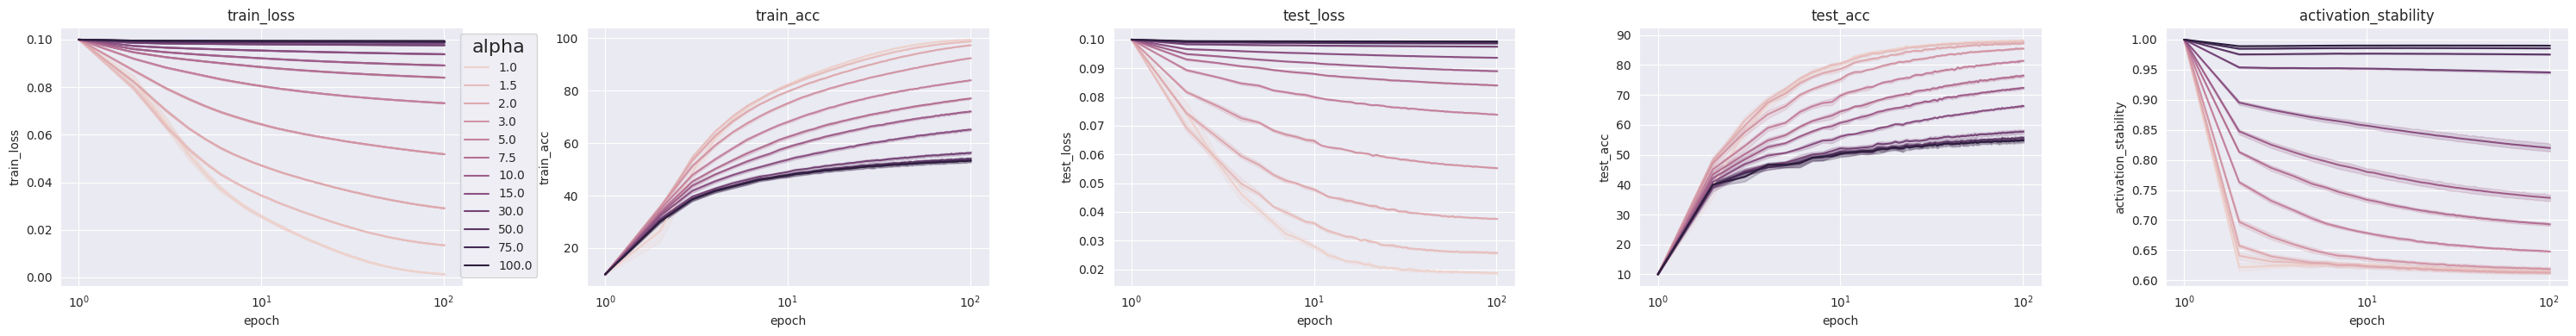

In [6]:
cols_to_plot = ['train_loss', 'train_acc', 'test_loss', 'test_acc', 'activation_stability']
fig = plot_results_sns(model_training_df, "alpha", "epoch", cols_to_plot, figsize=(4,6))

In [15]:
model_training_df

,alpha,seed,epoch,train_loss,train_loss_scaled,train_acc,test_loss,test_loss_scaled,test_acc,grad_norm,weight_norm,activation_stability
0,2.0,37,0,0.100000,0.025000,10.000,0.100000,0.025000,10.00,NaN,49.145736,1.000000
1,2.0,37,1,0.082238,0.019323,35.566,0.073120,0.016008,50.14,0.059137,49.352952,0.659995
2,2.0,37,2,0.070273,0.015242,53.348,0.067563,0.014254,58.47,0.052306,49.603732,0.642272
3,2.0,37,3,0.062607,0.012627,62.916,0.059150,0.011480,67.98,0.048841,49.828146,0.632355
4,2.0,37,4,0.057815,0.011019,68.268,0.055447,0.010071,72.57,0.054236,50.014654,0.627830
...,...,...,...,...,...,...,...,...,...,...,...,...
6055,2.0,17,96,0.029089,0.001317,97.158,0.037587,0.004919,87.02,0.041635,52.083351,0.616668
6056,2.0,17,97,0.029049,0.001304,97.284,0.037438,0.004890,87.27,0.040675,52.087533,0.616452
6057,2.0,17,98,0.029101,0.001325,97.164,0.037583,0.004959,87.21,0.070670,52.091847,0.616914
6058,2.0,17,99,0.029023,0.001298,97.278,0.037598,0.004929,87.03,0.047724,52.095986,0.616142


## Feature analysis results

### Manifold capacity and manifold geometry metrics

In [ ]:
# vgg11
capacity_folder = "/mnt/home/hlethi/ceph/learningGeometry_20240510/feature_analysis_main"
capacity_template = "result_alpha-{alpha}_decay-0.0_fsData-CIFAR-10_lr-1.0_model-VGG11_numCls-10_numSmpl-50_optim-SGD_sampleFunc-random_seed-{seed}_subSeed-{subSeed}_task-CIFAR-10_epoch_{epoch}.pkl"
glob_pattern = "alpha-*_decay-0.0_fsData-CIFAR-10_lr-1.0_model-VGG11_numCls-10_numSmpl-50_optim-SGD_sampleFunc-random_seed-*_subSeed-*_task-CIFAR-10"

In [8]:
capacity_df = plot_utils.load_results_to_df(capacity_folder, capacity_template, sub_folders=True, glob_pattern=glob_pattern)

In [11]:
cols = ['alpha', 'seed', 'subSeed', 'epoch', 'alpha_cor_mf', 'D_M_cor', 'R_M_cor',
       'cor_center', 'cor_axes', 'cor_center_axes']
short_capacity_df = capacity_df[cols]
short_capacity_df["eta"] = short_capacity_df["alpha"].apply(lambda x: round(1/x, 3))
short_capacity_df = short_capacity_df.rename(columns=RENAME_DICT)

/tmp/ipykernel_104381/3430058152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_capacity_df["eta"] = short_capacity_df["alpha"].apply(lambda x: round(1/x, 3))


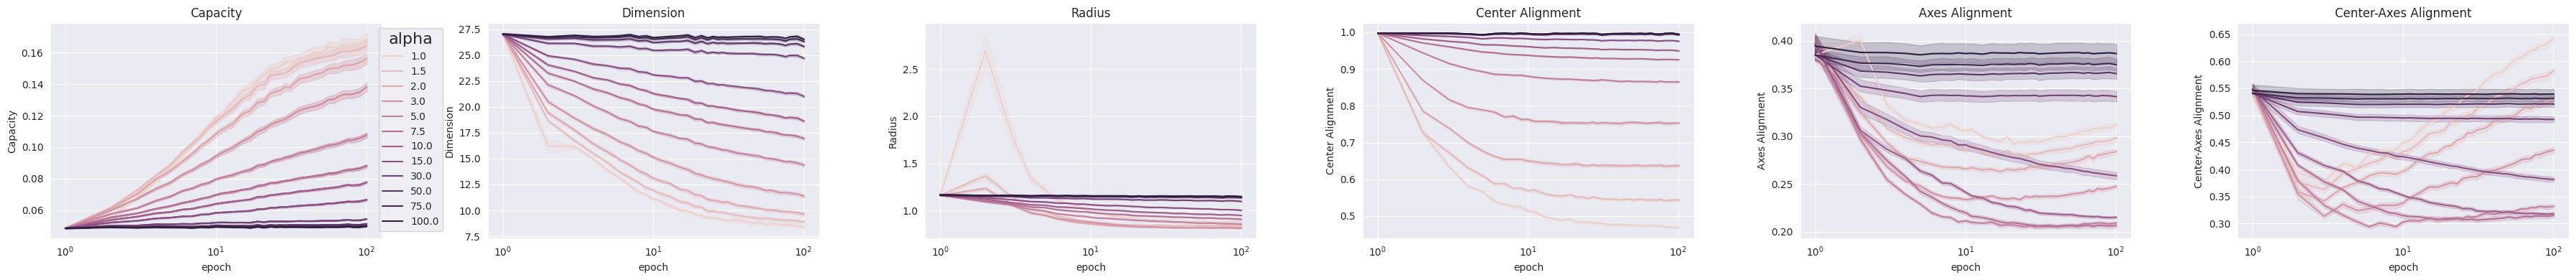

In [14]:
cols_to_plot = ['Capacity', 'Dimension', 'Radius', 'Center Alignment', 'Axes Alignment', 'Center-Axes Alignment']
fig = plot_results_sns(short_capacity_df, "alpha", "epoch", cols_to_plot, figsize=(4,6))

### Weight-based metrics

In [24]:
# vgg
weight_folder = "/mnt/home/hlethi/ceph/learningGeometry_20240510/weight_analysis"
weight_template = "alpha-{alpha}_decay-0.0_lr-1.0_model-VGG11_optim-SGD_seed-{seed}_task-CIFAR-10.pkl"
weight_df = plot_utils.load_results_to_df(weight_folder, weight_template, sub_folders=False)

cache_filename='/mnt/home/hlethi/ceph/learningGeometry_20240510/weight_analysis/alpha-_decay-0.0_lr-1.0_model-VGG11_optim-SGD_seed-_task-CIFAR-10.pkl'


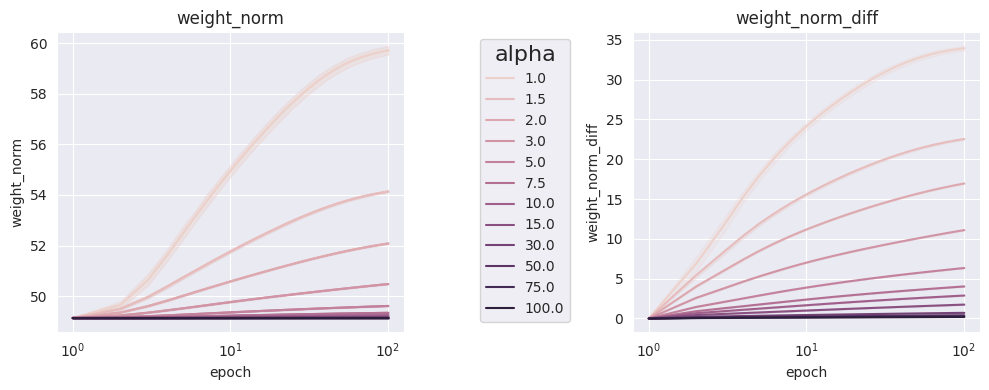

In [26]:
cols_to_plot = ["weight_norm", "weight_norm_diff"]
fig = plot_results_sns(weight_df, "alpha", "epoch", cols_to_plot, figsize=(4,5))

### Kernel-based metrics

In [21]:
# vgg
kernel_folder = "/mnt/home/hlethi/ceph/learningGeometry_20240510/kernels"
kernel_template = "alpha-{alpha}_decay-0.0_lr-1.0_model-VGG11_numCls-10_optim-SGD_seed-{seed}_task-CIFAR-10.pkl"
kernel_df = plot_utils.load_results_to_df(kernel_folder, kernel_template, sub_folders=False)

cache_filename='/mnt/home/hlethi/ceph/learningGeometry_20240510/kernels/alpha-_decay-0.0_lr-1.0_model-VGG11_numCls-10_optim-SGD_seed-_task-CIFAR-10.pkl'


  0%|          | 0/1 [00:00<?, ?it/s]

Template alpha-{alpha}_decay-0.0_lr-1.0_model-VGG11_numCls-10_optim-SGD_seed-{seed}_task-CIFAR-10.pkl not match with filename alpha-_decay-0.0_lr-1.0_model-VGG11_numCls-10_optim-SGD_seed-17_task-CIFAR-10.pkl!


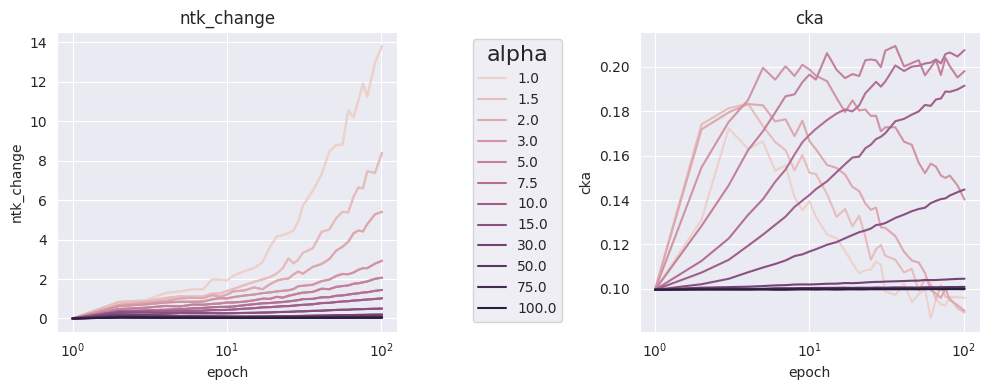

In [22]:
cols_to_plot = ["ntk_change", "cka"]
fig = plot_results_sns(kernel_df, "alpha", "epoch", cols_to_plot, figsize=(4,5))

## CIFAR-100 dataset

### Linear probe results

In [27]:
# vgg11
linear_probe_folder = "/mnt/home/hlethi/ceph/learningGeometry_20240510/linear_probe/training_state"
linear_probe_template = "alpha-{alpha}_decay-0.0_fsData-CIFAR-100_lr-1.0_model-VGG11_numCls-10_optim-SGD_seed-{seed}_task-CIFAR-10_epoch_{epoch}.pkl"

In [28]:
linear_probe_df = plot_utils.load_results_to_df(linear_probe_folder, linear_probe_template, sub_folders=True)
display(linear_probe_df)

,alpha,seed,epoch,epoch_lp,train_loss,train_acc,test_loss,test_acc
0,7.5,13,100,0,4.605515,1.204,4.605619,1.21
1,7.5,13,100,1,3.564935,16.434,3.198427,22.57
2,7.5,13,100,2,3.129313,24.116,3.024718,25.91
3,7.5,13,100,3,2.989901,26.680,2.921951,28.14
4,7.5,13,100,4,2.913039,28.250,2.867187,29.07
...,...,...,...,...,...,...,...,...
2744,50.0,13,100,45,3.504731,18.850,3.449482,20.09
2745,50.0,13,100,46,3.502696,19.080,3.446453,20.10
2746,50.0,13,100,47,3.502495,19.024,3.441335,20.38
2747,50.0,13,100,48,3.504234,18.796,3.448415,20.32


In [ ]:
max_col = "test_acc"
group_by_cols = ["alpha", "epoch", "seed"]
linear_probe_max = linear_probe_df.groupby(group_by_cols).idxmax()
idx = list(linear_probe_max[max_col])
linear_probe_max["train_acc"] = list(linear_probe_df["train_acc"][idx])
linear_probe_max["train_loss"] = list(linear_probe_df["train_loss"][idx])
linear_probe_max["test_loss"] = list(linear_probe_df["test_loss"][idx])
linear_probe_max["test_acc"] = list(linear_probe_df["test_acc"][idx])
linear_probe_max = linear_probe_max.reset_index()

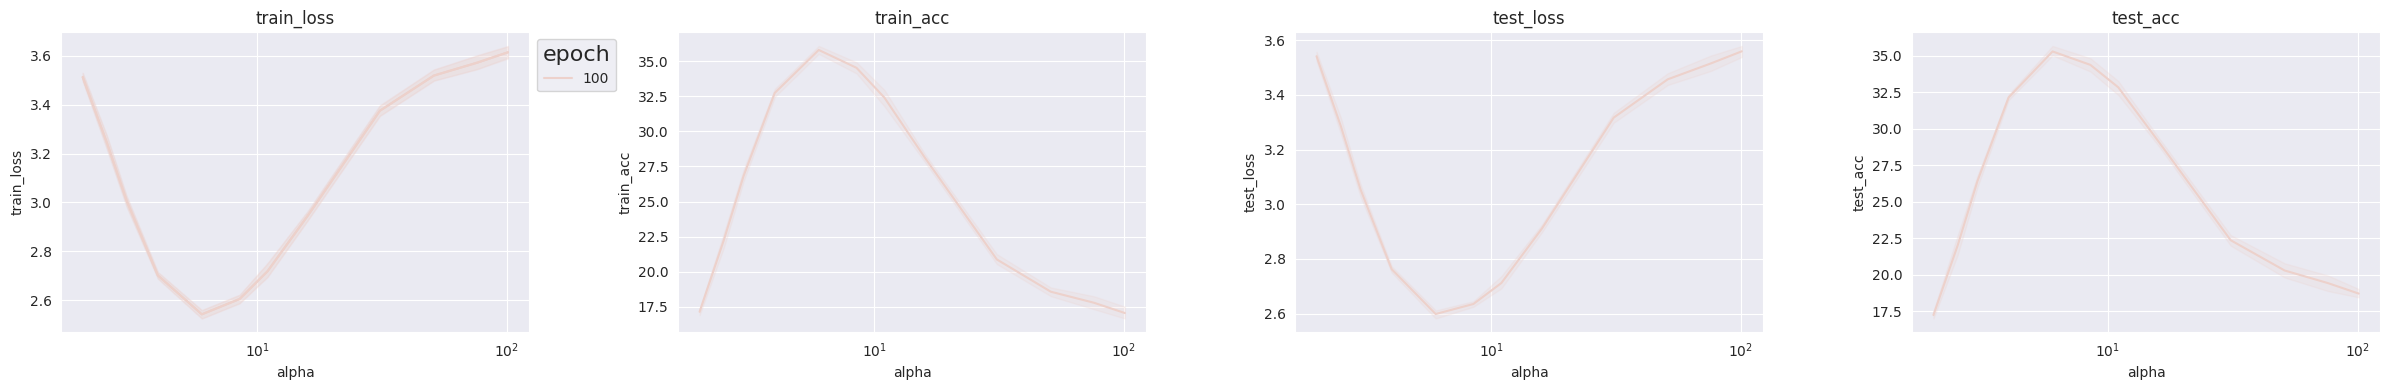

In [32]:
cols_to_plot = ['train_loss', 'train_acc', 'test_loss', 'test_acc']
fig = plot_results_sns(linear_probe_max, "epoch", "alpha", cols_to_plot, figsize=(4,6))

### Manifold capacity and manifold geometry

In [33]:
# vgg11
lp_capacity_folder = "/mnt/home/hlethi/ceph/learningGeometry_20240510/linear_probe/capacity"
lp_capacity_template = "alpha-{alpha}_decay-0.0_fsData-CIFAR-100_lr-1.0_model-VGG11_numCls-10_numSmpl-50_optim-SGD_sampleFunc-random_seed-{seed}_subSeed-{subSeed}_task-CIFAR-10_epoch_{epoch}.pkl"
lp_glob_pattern = "alpha-*_decay-0.0_fsData-CIFAR-100_lr-1.0_model-VGG11_numCls-10_numSmpl-50_optim-SGD_sampleFunc-random_seed-*_subSeed-*_task-CIFAR-10"

In [ ]:
lp_capacity_df = plot_utils.load_results_to_df(lp_capacity_folder, lp_capacity_template, sub_folders=True, glob_pattern=lp_glob_pattern)
display(lp_capacity_df)

,i,j,shuffle,i_P,seed,capacity,dimension,radius,capacity_geometric_approx,capacity_geometric_approx_corrected,...,axes_alignment_scaled_diag,center_axes_alignment_scaled_diag,center_alignment_scaled_off,axes_alignment_scaled_off,center_axes_alignment_scaled_off,layer,alpha,subSeed,epoch,shuffled
0,2.666667,6.333333,0.0,0.5,7,0.096391,15.681277,1.420180,0.123548,0.096390,...,32.274243,2.336360,-517.610083,-27.162054,-4.065859,view,1.5,49,100,False
1,2.666667,6.333333,0.0,0.5,7,0.105757,15.342944,1.217031,0.130077,0.105757,...,4.864442,-1.069004,-208.342853,-1.356004,0.378464,view,5.0,49,100,False
2,2.666667,6.333333,0.0,0.5,13,0.075421,18.315248,1.289565,0.092405,0.075421,...,6.573948,-5.807591,-939.556333,-1.640365,4.210290,view,15.0,27,100,False
3,2.666667,6.333333,0.0,0.5,7,0.081868,17.175274,1.424674,0.099887,0.081868,...,14.541917,-1.743078,-275.752940,-9.335308,0.325828,view,2.0,18,100,False
4,2.666667,6.333333,0.0,0.5,37,0.074999,17.436962,1.501763,0.089701,0.074999,...,26.195517,0.271204,-382.172969,-20.656496,-1.764903,view,1.5,18,100,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2.666667,6.333333,0.0,0.5,17,0.088414,16.931659,1.262355,0.104993,0.088414,...,5.408799,-2.001363,-430.973271,-1.317766,1.008749,view,10.0,98,100,False
596,2.666667,6.333333,0.0,0.5,47,0.068166,15.463259,1.156521,0.117906,0.068166,...,17.293543,-40.782911,-2691.803097,-2.253454,19.783490,view,75.0,64,100,False
597,2.666667,6.333333,0.0,0.5,13,0.096561,19.124394,1.363261,0.123393,0.096561,...,9.316953,-2.051559,-356.118803,-4.079554,0.982603,view,3.0,82,100,False
598,2.666667,6.333333,0.0,0.5,13,0.078904,18.027309,1.358572,0.093425,0.078904,...,8.662306,-1.421171,-304.665783,-3.866952,0.366468,view,3.0,90,100,False


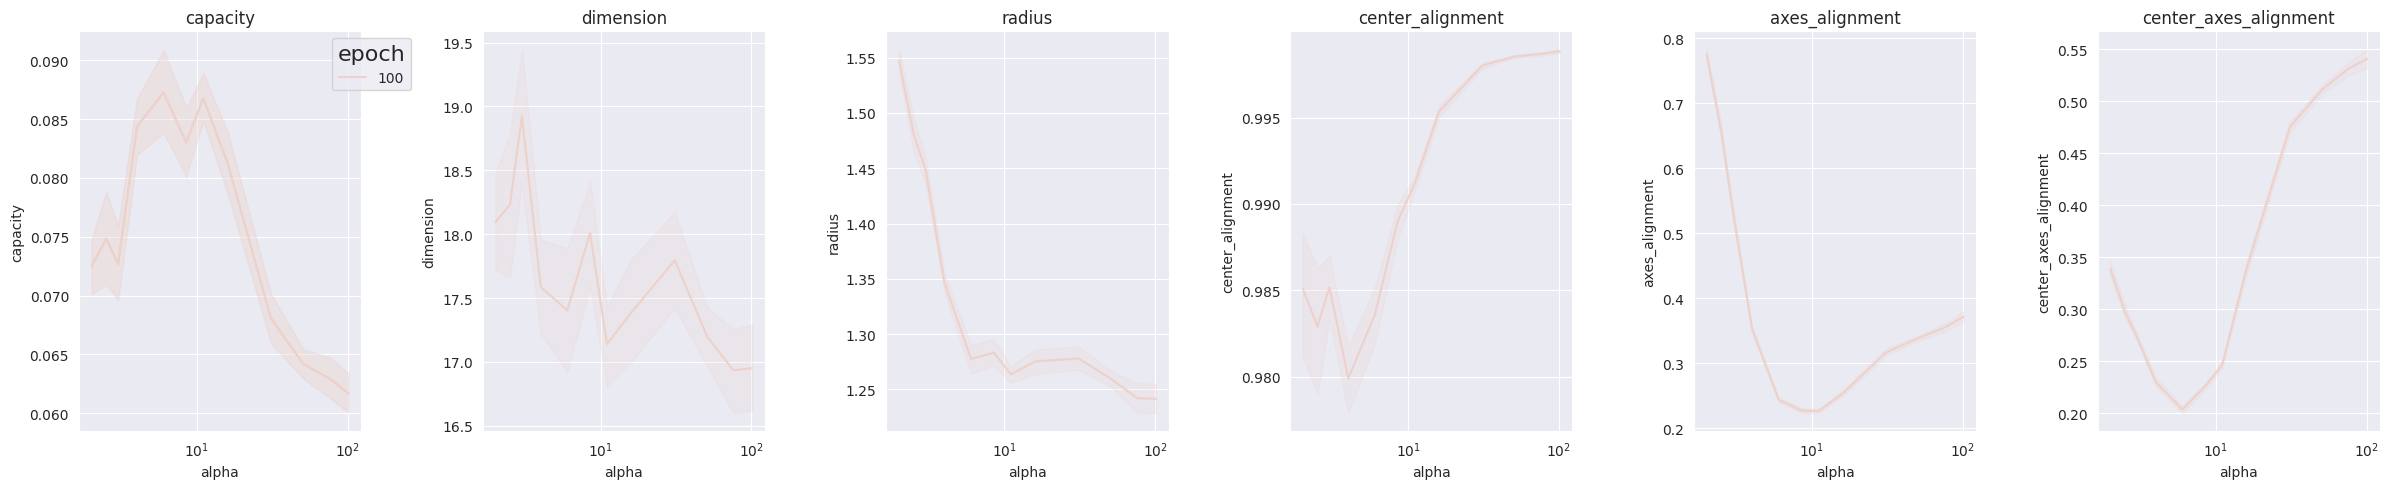

In [36]:
cols = ['alpha', 'seed', 'subSeed', 'epoch', 'capacity', 'dimension', 'radius',
       'center_alignment', 'axes_alignment', 'center_axes_alignment']
short_lp_capacity_df = lp_capacity_df[cols]
cols_to_plot = ['capacity', 'dimension', 'radius', 'center_alignment', 'axes_alignment', 'center_axes_alignment']
fig = plot_results_sns(short_lp_capacity_df, "epoch", "alpha", cols_to_plot, figsize=(5,4))

## CIFAR-10C dataset

### Corruption evaluation results

In [37]:
# VGG11
eval_corrupt_folder = "/mnt/home/hlethi/ceph/learningGeometry_20240510/eval_corrupt/model_eval"
eval_corrupt_template = "alpha-{alpha}_decay-0.0_fsData-{corruption}_lr-1.0_model-VGG11_optim-SGD_seed-{seed}_task-CIFAR-10.pkl"
eval_corrupt_df = plot_utils.load_results_to_df(eval_corrupt_folder, eval_corrupt_template, sub_folders=False)
display(eval_corrupt_df)

cache_filename='/mnt/home/hlethi/ceph/learningGeometry_20240510/eval_corrupt/model_eval/alpha-_decay-0.0_fsData-_lr-1.0_model-VGG11_optim-SGD_seed-_task-CIFAR-10.pkl'


,alpha,corruption,seed,epoch,severity,test_loss,test_acc,test_loss_scaled
0,30.0,glass_blur,7,100,3,0.097780,54.18,0.000072
1,30.0,glass_blur,7,100,1,0.097680,53.39,0.000073
2,30.0,glass_blur,7,100,2,0.097691,53.62,0.000073
3,30.0,glass_blur,7,100,4,0.097757,50.92,0.000076
4,30.0,glass_blur,7,100,5,0.097832,52.48,0.000074
...,...,...,...,...,...,...,...,...
4495,10.0,glass_blur,47,100,3,0.091454,60.33,0.000554
4496,10.0,glass_blur,47,100,1,0.092283,52.12,0.000643
4497,10.0,glass_blur,47,100,2,0.092157,53.53,0.000627
4498,10.0,glass_blur,47,100,4,0.093568,42.27,0.000758


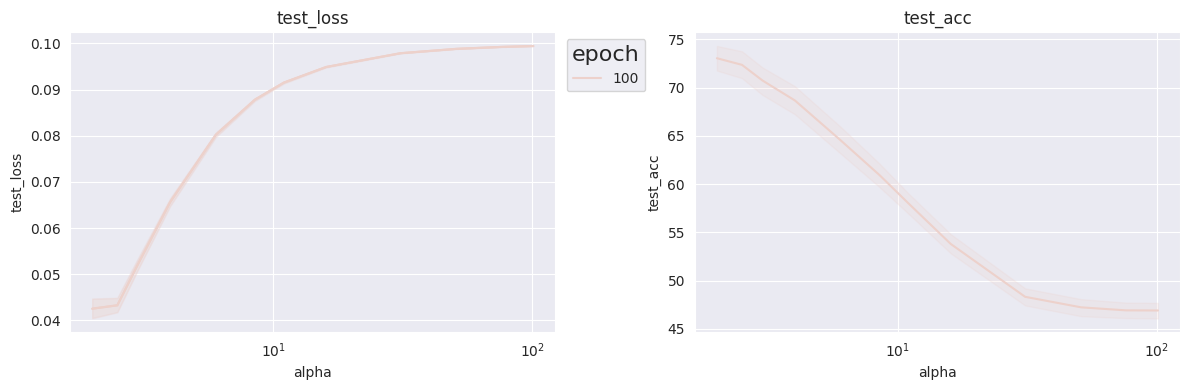

In [45]:
cols_to_plot = ['test_loss', 'test_acc']
fig = plot_results_sns(eval_corrupt_df, "epoch", "alpha", cols_to_plot, figsize=(4,6))

## Fig 4C (Learning Stages Results)

## Fig 6 (OOD Results)

### Fig 6B

In [46]:
cifar_10_df = model_training_df[(model_training_df["epoch"] == max_epoch)]
cifar_100_df = linear_probe_max[(linear_probe_max["epoch"] == max_epoch)]
cifar_10c_df = eval_corrupt_df[(eval_corrupt_df["epoch"] == max_epoch)]
cifar_10c_df = cifar_10c_df.drop(columns=["corruption", "severity"]).groupby(["alpha", "seed"]).mean().reset_index() # take the mean accuracy across corruption and accuracy

In [47]:
cifar_10_df["dataset"] = "CIFAR-10"
cifar_100_df["dataset"] = "CIFAR-100"
cifar_10c_df["dataset"] = "CIFAR-10C"
col_names = ["alpha", "dataset", "test_acc", "seed"]
perf_df = pd.concat([cifar_10_df[col_names], cifar_100_df[col_names], cifar_10c_df[col_names]])
perf_df = perf_df.rename(columns={"test_acc": "Test Accuracy"})
perf_df["eta"] = perf_df["alpha"].apply(lambda x: round(1/x, 3)) #vgg
# perf_df["eta"] = perf_df["alpha"].apply(lambda x: round(0.2/x, 3)) #resnet
perf_df = perf_df.rename(columns={"eta": ETA_LATEX})
display(perf_df)

/tmp/ipykernel_104381/2351082430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cifar_10_df["dataset"] = "CIFAR-10"


,alpha,dataset,Test Accuracy,seed,$\overline{\eta}$
100,2.0,CIFAR-10,87.060000,37,0.500
201,5.0,CIFAR-10,81.530000,17,0.200
302,7.5,CIFAR-10,77.280000,17,0.133
403,7.5,CIFAR-10,76.660000,37,0.133
504,100.0,CIFAR-10,55.550000,13,0.010
...,...,...,...,...,...
55,100.0,CIFAR-10C,45.390400,7,0.010
56,100.0,CIFAR-10C,47.524533,13,0.010
57,100.0,CIFAR-10C,46.971467,17,0.010
58,100.0,CIFAR-10C,48.482933,37,0.010


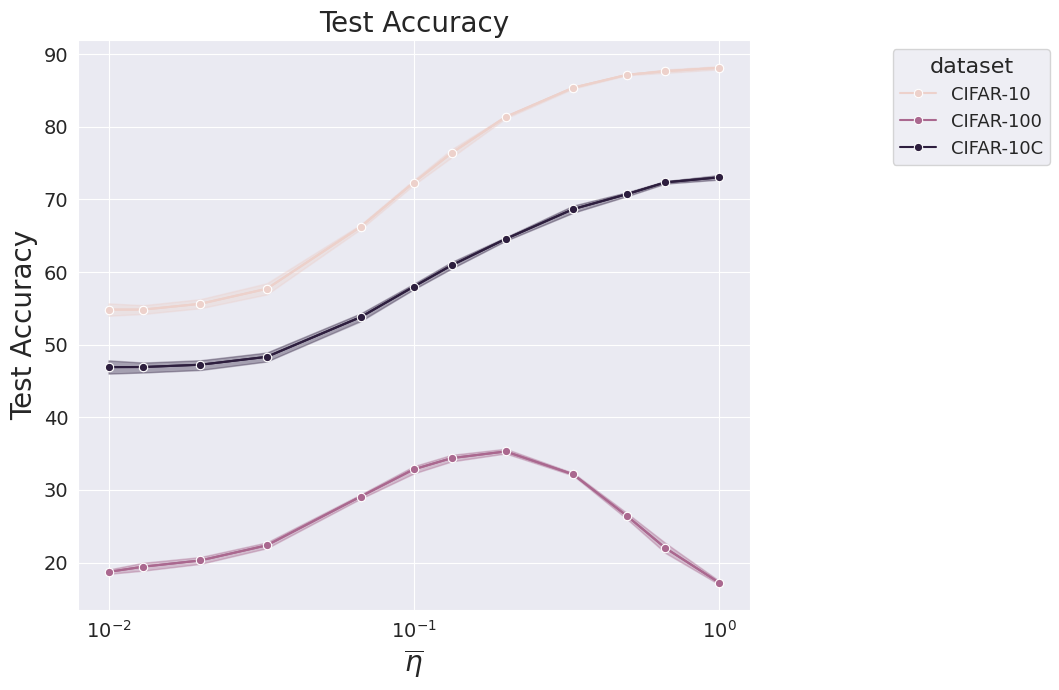

In [50]:
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
fig = plot_results_sns(perf_df,  "dataset", ETA_LATEX, ["Test Accuracy"], plus_one=False, figsize=(7,9), marker="o")

### Fig 6C